In [92]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
sns.set_palette("Set2")
palette = sns.color_palette("Set2")

import pycountry
import pycountry_convert as pc

import folium

from datetime import datetime

from src.utils.locationHelper import LocationHelper
from src.utils.preProcessingHelper import PreProcessRatings
import src.utils.preProcessingHelper as preProcessingHelper

from pandas.api.types import CategoricalDtype

import scipy.stats as stats
from scipy.stats import  kruskal, anderson, shapiro
import random

import src.utils.USClimateAndWeatherHelper as WaH
import plotly.express as px
import plotly.graph_objects as go

from src.utils.jeanneHelper import JeanneHelper, get_rating_per_month
helper = JeanneHelper()

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
ph = PreProcessRatings("BeerAdvocate")
reviews_df = ph.get_dataframe(dataset="reviews", additinal_cols=["country_name", "country_code3", "state", "date_object", "month", "year", "style", "beer_name", "beer_id"])
reviews_df = reviews_df[(reviews_df["year"] >= 2002) & (reviews_df["country_code3"] == "USA")]

start parsing the beer reviews for BeerAdvocate
finished parsing the beer reviews for BeerAdvocate with direct conversion
now you can get dataframes with the "get_dataframe" handle
Country svalbard and jan mayen islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country aotearoa could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country fiji islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country south georgia and south sandwich islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
From 2589586 reviews, 2494478 have a location (corresponding to the user) and 95108 do not have a location


In [9]:
reviews_df.to_csv("src/data/beerAdvocateReviewsUSA.csv")

In [237]:
def monthly_avg_ci_fig(df: pd.DataFrame, title: str):
    stats_df = df.groupby("month")["rating"].agg(["mean", "count", "std"]).reset_index()
    months = stats_df["month"].to_numpy()
    means = stats_df["mean"].to_numpy()
    ci_high = np.array([m + 1.96*s/np.sqrt(c) for _, m, c, s in stats_df.values])
    ci_low = np.array([m - 1.96*s/np.sqrt(c) for _, m, c, s in stats_df.values])

    # print(ci_high)
    print(f'Variance over the means: {np.var(means)}')
    fig = px.line(x=months, y=means,
                title=title,
                labels={'x': 'Month', 'y': 'Avg Rating'})
    fig.add_scatter(
            x=np.concat((months, months[::-1])), # x, then x reversed
            y=np.concat((ci_high, ci_low[::-1])), # upper, then lower reversed
            fill='toself',
            fillcolor='rgba(0,100,80,0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False
        )
    return fig

fig = monthly_avg_ci_fig(reviews_df, f'Avg rating per month with 95% confidence interval, n={reviews_df.shape[0]}')
fig.show()


Variance over the means: 0.00014598136056148445


# histogram with total nr of reviews:

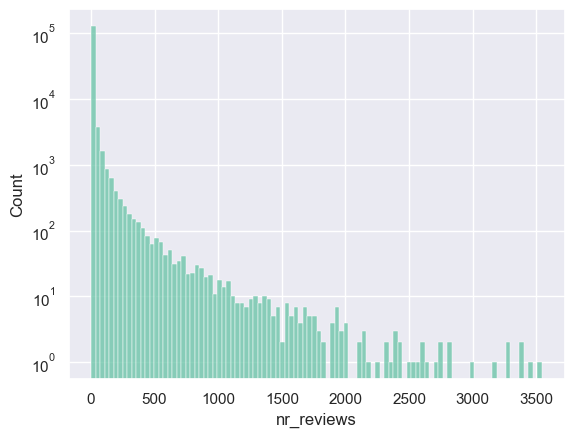

In [263]:
nr_agg = reviews_df.groupby("beer_id").agg(nr_reviews = ("rating", "count")).reset_index()
h = sns.histplot(nr_agg, x="nr_reviews", bins=100)
h.set_yscale('log')
# h.set_ybound(upper=200)

## Get most significant seasonal ratings beers

In [254]:
CUTOFF = 500 # cutoff for beers to get into the stats

print("all shape: ", reviews_df.shape[0])

# trash all with less than 12 ratings

nr_agg = reviews_df.groupby("beer_id").agg(count = ("rating", "count")).reset_index()
nr_agg = nr_agg[nr_agg["count"] >= CUTOFF]
ids = nr_agg["beer_id"]


print("reduced shape:", reviews_df[reviews_df["beer_id"].isin(ids)].shape[0])

reviews_df_more12 = reviews_df[reviews_df["beer_id"].isin(ids)]

monthly_avg_ci_fig(reviews_df_more12, f'Avg rating per month with 95% confidence interval with at least {CUTOFF} reviews, n={reviews_df_more12.shape[0]}')


all shape:  2239823
reduced shape: 711007
Variance over the means: 0.00026220351599591686


In [258]:
# residual
residual_df = reviews_df[~reviews_df["beer_id"].isin(ids)]
monthly_avg_ci_fig(residual_df, f'Avg rating per month with 95% confidence interval with at most {CUTOFF} reviews, n={residual_df.shape[0]}')


Variance over the means: 6.248338703890667e-05


In [249]:
monthly_reviews_df = reviews_df_more12.groupby(["beer_id", "month"]).agg(mean_rating = ("rating", "mean")).reset_index()
monthly_reviews_df = monthly_reviews_df.pivot(index="beer_id", columns="month", values="mean_rating")
# monthly_reviews_df.head(10)
print(f'shape without removing rows containing nans: {monthly_reviews_df.shape[0]}')

# remove na rows
monthly_reviews_df = monthly_reviews_df[monthly_reviews_df.notna().all(axis=1)]
print(f'shape after removing rows containing nans: {monthly_reviews_df.shape[0]}')

shape without removing rows containing nans: 239
shape after removing rows containing nans: 239


In [226]:
monthly_reviews_df["var"] = np.nanvar(monthly_reviews_df.to_numpy(), axis=1) #var ignoring nans

In [ ]:
# beer_id's sorted in ascending variance
seasonal_beer_ids = monthly_reviews_df.sort_values("var", ascending=False).head(int(0.1 * len(monthly_reviews_df))).index

In [238]:
variance_reviews_df = reviews_df[reviews_df["beer_id"].isin(seasonal_beer_ids)]
monthly_avg_ci_fig(variance_reviews_df,
                   title = f'Avg rating per month for high variance beers with 95% confidence interval, n={variance_reviews_df.shape[0]}')

Variance over the means: 0.0049782992066148704


In [239]:
kruskal(*get_rating_per_month(variance_reviews_df))


KruskalResult(statistic=np.float64(313.64682057873375), pvalue=np.float64(1.1628177900460184e-60))

In [240]:
lowvariance_reviews_df = reviews_df_more12[~reviews_df_more12["beer_id"].isin(seasonal_beer_ids)]
monthly_avg_ci_fig(lowvariance_reviews_df,
                   title=f'Avg rating per month for residual beers with 95% confidence interval, n={lowvariance_reviews_df.shape[0]}')

Variance over the means: 0.00013126486730887798


In [233]:
kruskal(*get_rating_per_month(lowvariance_reviews_df))

KruskalResult(statistic=np.float64(184.79896082599265), pvalue=np.float64(1.045942533860179e-33))

In [253]:
# identify beer with highest variance
most_var_beer_df = reviews_df[reviews_df["beer_id"] == seasonal_beer_ids[3]]
monthly_avg_ci_fig(most_var_beer_df,
                   title = f'Avg rating per month for beer with highest variance with 95% confidence interval, n={most_var_beer_df.shape[0]}')

Variance over the means: 0.025798978063685366
